## **INITIAL SETUP**

In [1]:
#@title Install libraries

!pip install xgboost
!pip install imbalanced-learn
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 811 kB/s 


In [2]:
#@title Import libraries
# Maths and Visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
from datetime import timedelta
import plotly.express as px
from matplotlib import colors
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import boxcox
import plotly.graph_objs as go 
import plotly.offline as pyoff 

# Clustering and Data standardization libraries

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import category_encoders as ce
from imblearn.over_sampling import SMOTE, SVMSMOTE
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer


import warnings
warnings.filterwarnings('ignore')
import datetime 

In [3]:
#@title Define functions
# Chart funtions
def plot_Boxplot(features_set, df):
    plt.rcParams["figure.figsize"] = (20,5)
    fig, axs = plt.subplots(1, len(features))
    cnt = 0
    for i in range(len(features)):
        axs[i].boxplot(df[features[cnt]])
        axs[i].set_title('distribution of '+ features[cnt])
        cnt +=1

def plot_Hist(features, df):
    plt.rcParams["figure.figsize"] = (20,5)
    fig, axs = plt.subplots(1, len(features))
    cnt = 0
    for i in range(len(features)):
        axs[i].hist(df[features[cnt]])
        axs[i].set_title('distribution of '+ features[cnt])
        cnt +=1
def qualify_R_testing(distances, labels, no_clusters):
    dis_intra = 0
    dis_inter = 0
    i = 0
    for label in labels:
        dis_intra = dis_intra + distances[i][label]
        dis_inter = dis_inter + np.mean(distances[0, [i for i in range(no_clusters) if i!=label]])
        i = i + 1
    return dis_intra/dis_inter


# Skewness 
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(df_customer_RFM_Score[x], ax=ax[0,0])
    sns.distplot(np.log(df_customer_RFM_Score[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(df_customer_RFM_Score[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(df_customer_RFM_Score[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(df_customer_RFM_Score[x].skew().round(2))
    print(np.log(df_customer_RFM_Score[x]).skew().round(2))
    print(np.sqrt(df_customer_RFM_Score[x]).skew().round(2))
    print(pd.Series(stats.boxcox(df_customer_RFM_Score[x])[0]).skew().round(2))


## **DATA PREPARATION**

In [4]:
df = pd.read_excel('/content/AdventureWorks Sales.xlsx')

In [18]:
df_sales_data_raw = pd.read_excel('/content/AdventureWorks Sales.xlsx',sheet_name = 'Sales_data')
df_sales_data_raw.head()

,SalesOrderLineKey,ResellerKey,CustomerKey,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,SalesTerritoryKey,Order Quantity,Unit Price,Extended Amount,Unit Price Discount Pct,Product Standard Cost,Total Product Cost,Sales Amount
0,43659001,676,-1,349,20170702,20170712,20170709.0,5,1,2024.994,2024.994,0,1898.0944,1898.0944,2024.994
1,43659002,676,-1,350,20170702,20170712,20170709.0,5,3,2024.994,6074.982,0,1898.0944,5694.2832,6074.982
2,43659003,676,-1,351,20170702,20170712,20170709.0,5,1,2024.994,2024.994,0,1898.0944,1898.0944,2024.994
3,43659004,676,-1,344,20170702,20170712,20170709.0,5,1,2039.994,2039.994,0,1912.1544,1912.1544,2039.994
4,43659005,676,-1,345,20170702,20170712,20170709.0,5,1,2039.994,2039.994,0,1912.1544,1912.1544,2039.994


In [19]:
df_sales_data = df_sales_data_raw.drop(columns = ['ResellerKey','ProductKey','DueDateKey','ShipDateKey','Order Quantity','Order Quantity','Unit Price','Extended Amount','Unit Price Discount Pct','Product Standard Cost','Total Product Cost'])
df_sales_data.head()

,SalesOrderLineKey,CustomerKey,OrderDateKey,SalesTerritoryKey,Sales Amount
0,43659001,-1,20170702,5,2024.994
1,43659002,-1,20170702,5,6074.982
2,43659003,-1,20170702,5,2024.994
3,43659004,-1,20170702,5,2039.994
4,43659005,-1,20170702,5,2039.994


In [20]:
df_sales_data['OrderDateKey'] = pd.to_datetime(df_sales_data['OrderDateKey'], format ='%Y%m%d')

In [21]:
df_sales_data_final = df_sales_data[df_sales_data['CustomerKey'] != -1]
df_sales_data_final.head()

,SalesOrderLineKey,CustomerKey,OrderDateKey,SalesTerritoryKey,Sales Amount
60855,43697001,21768,2017-07-01,6,3578.2700
60856,43698001,28389,2017-07-01,7,3399.9900
60857,43699001,25863,2017-07-01,1,3399.9900
60858,43700001,14501,2017-07-01,4,699.0982
60859,43701001,11003,2017-07-01,9,3399.9900


## **EDA**

:***1. MONTHLY GROWTH RATE ***

In [22]:
df_sales_data_final.head()

,SalesOrderLineKey,CustomerKey,OrderDateKey,SalesTerritoryKey,Sales Amount
60855,43697001,21768,2017-07-01,6,3578.2700
60856,43698001,28389,2017-07-01,7,3399.9900
60857,43699001,25863,2017-07-01,1,3399.9900
60858,43700001,14501,2017-07-01,4,699.0982
60859,43701001,11003,2017-07-01,9,3399.9900


In [23]:
df_sales_data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60398 entries, 60855 to 121252
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   SalesOrderLineKey  60398 non-null  int64         
 1   CustomerKey        60398 non-null  int64         
 2   OrderDateKey       60398 non-null  datetime64[ns]
 3   SalesTerritoryKey  60398 non-null  int64         
 4   Sales Amount       60398 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.8 MB


In [24]:
df_sales_data_final['OrdYearMonth']= df_sales_data_final['OrderDateKey'].map(lambda x: x.year*100 + x.month)

In [25]:
df_sales_data_final.head()

,SalesOrderLineKey,CustomerKey,OrderDateKey,SalesTerritoryKey,Sales Amount,OrdYearMonth
60855,43697001,21768,2017-07-01,6,3578.2700,201707
60856,43698001,28389,2017-07-01,7,3399.9900,201707
60857,43699001,25863,2017-07-01,1,3399.9900,201707
60858,43700001,14501,2017-07-01,4,699.0982,201707
60859,43701001,11003,2017-07-01,9,3399.9900,201707


In [26]:
df_sales_data_final['OrdYearMonth'].unique()
df_revenue = df_sales_data_final.groupby('OrdYearMonth')['Sales Amount'].sum().reset_index()

In [27]:
df_revenue.head()

,OrdYearMonth,Sales Amount
0,201707,934028.7442
1,201708,519494.1412
2,201709,513329.4740
3,201710,561681.4758
4,201711,737839.8214


In [28]:
df_revenue['pct_change'] = df_revenue['Sales Amount'].pct_change()
df_revenue.head()

,OrdYearMonth,Sales Amount,pct_change
0,201707,934028.7442,NaN
1,201708,519494.1412,-0.443814
2,201709,513329.4740,-0.011867
3,201710,561681.4758,0.094193
4,201711,737839.8214,0.313627


In [29]:
#visualization
import plotly.graph_objs as go 
import plotly.offline as pyoff 
plot_data =[
    go.Scatter(
        x=df_revenue[df_revenue['OrdYearMonth'] != '2017-07']['OrdYearMonth'],
        y=df_revenue[df_revenue['pct_change'] != '2017-07']['pct_change']
    )
]
plot_layout = go.Layout(
    xaxis={"type": "category"},
    title ='Monthly Grow Rate'
)
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.plot(fig)
fig.show()

**Monthly Total of Order**

In [30]:
df_highest_product = df_sales_data_raw.groupby('ProductKey')['Sales Amount'].sum().reset_index()
df_highest_product 

,ProductKey,Sales Amount
0,212,11385.1860
1,213,29031.3507
2,214,117355.8586
3,215,12098.0788
4,216,31866.8299
...,...,...
345,601,12244.9320
346,603,39581.4420
347,604,290298.6240
348,605,578174.3130


In [31]:
df_monthly_sales = df_sales_data_final.groupby('OrdYearMonth')['SalesOrderLineKey'].count().reset_index()

In [32]:
plot_data =[
    go.Bar(
        x=df_monthly_sales['OrdYearMonth'],
        y=df_monthly_sales['SalesOrderLineKey'],
    )
]
plot_layout = go.Layout(
    xaxis={"type": "category"},
    title ='Monthly Total of Order'
)
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.plot(fig)
fig.show()

**Monthly Total Of Revenue**

In [33]:
df_monthly_revenue = df_sales_data_final.groupby('OrdYearMonth')['Sales Amount'].sum().reset_index()

In [34]:
plot_data =[
    go.Bar(
        x=df_monthly_revenue['OrdYearMonth'],
        y=df_monthly_revenue['Sales Amount'],
    )
]
plot_layout = go.Layout(
    xaxis={"type": "category"},
    title ='Monthly Total of Revenue'
)
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.plot(fig)
fig.show()

***Top 5 territories with highest contribution to the total revenue ***

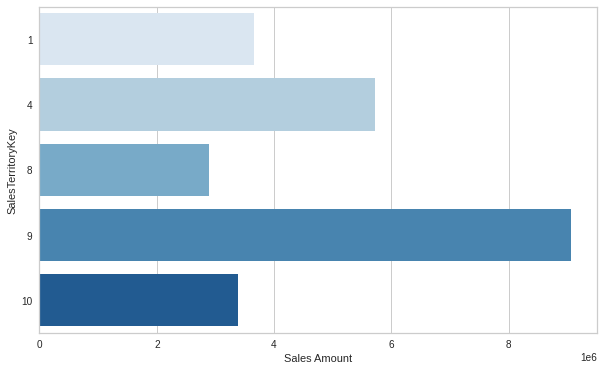

In [35]:
df_top5_region=df_sales_data_final.groupby('SalesTerritoryKey')['Sales Amount'].sum().reset_index().sort_values('Sales Amount', ascending = False)
plt.figure(figsize = (10,6))
sns.color_palette("Blues", as_cmap=True)
sns.barplot(x='Sales Amount', y='SalesTerritoryKey',data=df_top5_region[:5], orient = 'h', palette = 'Blues')

***Top 10 customers contribute most to the total revenue ***

Top 10 customers have the biggest contribution to the Total Revenue


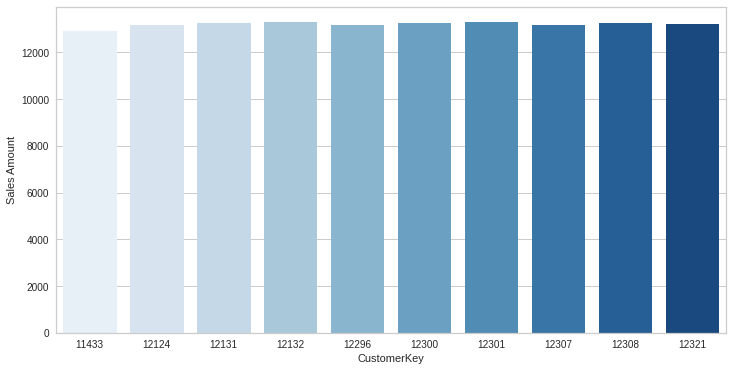

In [36]:
Top10Spending=df_sales_data_final.groupby('CustomerKey')['Sales Amount'].sum().reset_index().sort_values('Sales Amount',ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=Top10Spending['CustomerKey'],y=Top10Spending['Sales Amount'], palette="Blues")
print('Top 10 customers have the biggest contribution to the Total Revenue')

***Top 10 days have the highest revenue ***

Top 10 days have the largest contribution to Total Revenue


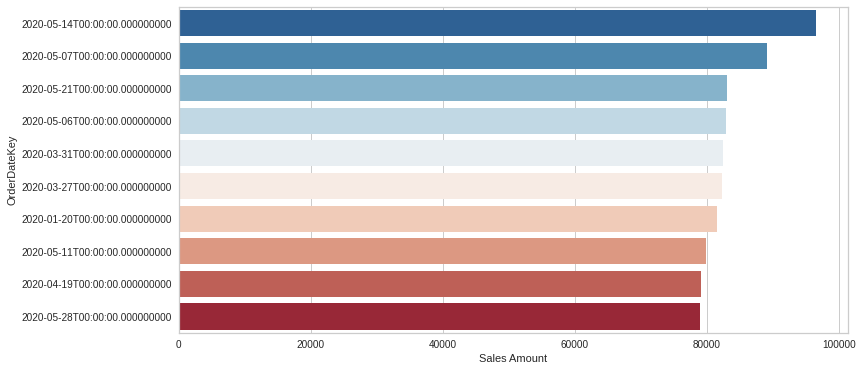

In [37]:
df1=df_sales_data_final.groupby('OrderDateKey').sum().reset_index().sort_values('Sales Amount', ascending = False)
df2= df1[['OrderDateKey','Sales Amount']].head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=df2['Sales Amount'],y=df2['OrderDateKey'],palette="RdBu_r")
print("Top 10 days have the largest contribution to Total Revenue")

***Top 10 days have the lowest revenue***

Top 10 days have the lowest contribution to Total Revenue


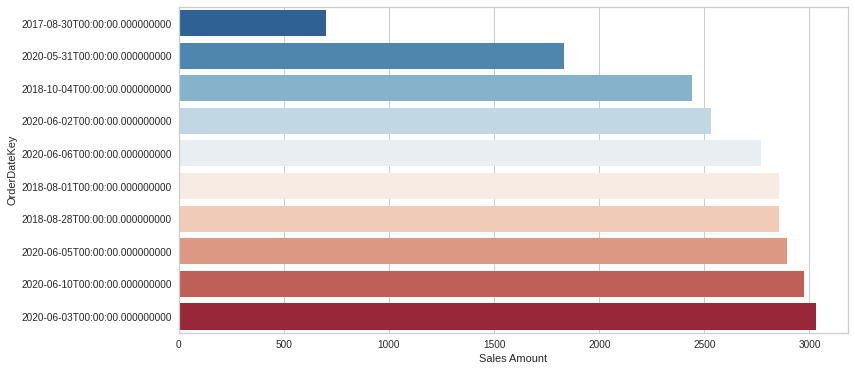

In [38]:
df3=df_sales_data_final.groupby('OrderDateKey').sum().reset_index().sort_values('Sales Amount', ascending = True)
df4= df3[['OrderDateKey','Sales Amount']].head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=df4['Sales Amount'],y=df4['OrderDateKey'], palette='RdBu_r')
print('Top 10 days have the lowest contribution to Total Revenue')

***Top 5 products have the highest sales amount***

Top 5 Product Lines with highest Sales Amount


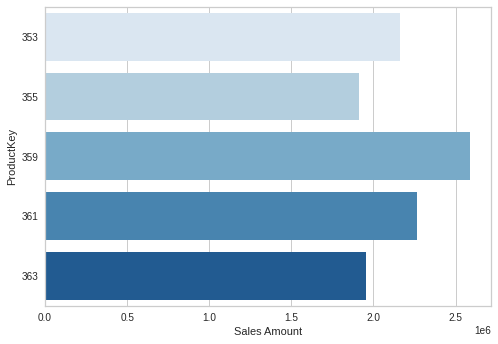

In [40]:
top_products_by_revenue = df_sales_data_raw.groupby("ProductKey")['Sales Amount'].sum().reset_index().sort_values("Sales Amount", ascending=False)
sns.barplot(x="Sales Amount", y="ProductKey", data=top_products_by_revenue[:5], orient = 'h', palette='Blues')
print("Top 5 Product Lines with highest Sales Amount")

***Cummulative of Sales Amount (using pareto to determine the contribution of each territory)***

In [41]:
top_ordersbyvalue_territories = df_sales_data_final.groupby("SalesTerritoryKey")["Sales Amount"].sum().reset_index().sort_values("Sales Amount", ascending=False)
top_ordersbyvalue_territories["% of Total Payments"] = (top_ordersbyvalue_territories["Sales Amount"] / top_ordersbyvalue_territories["Sales Amount"].sum()) * 100
top_ordersbyvalue_territories["Cum % of Total Payments"] = top_ordersbyvalue_territories["% of Total Payments"].cumsum() 

Number of territories contributing to 80% of total sales: 4 or in %: 40.0


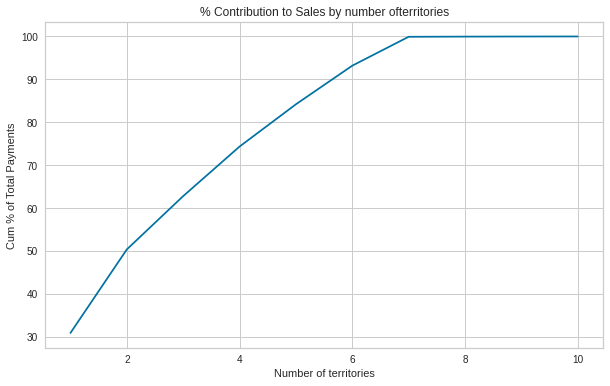

In [42]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(x=range(1,len(top_ordersbyvalue_territories)+1), y="Cum % of Total Payments", data=top_ordersbyvalue_territories)
ax.set_xlabel("Number of territories")
ax.set_title("% Contribution to Sales by number ofterritories")
print("Number of territories contributing to 80% of total sales:",
      len(top_ordersbyvalue_territories[top_ordersbyvalue_territories["Cum % of Total Payments"] <= 80]),
      "or in %:",
      (len(top_ordersbyvalue_territories[top_ordersbyvalue_territories["Cum % of Total Payments"] <= 80]) / len(top_ordersbyvalue_territories)) * 100)

In [43]:
top_ordersbyvalue_territories

,SalesTerritoryKey,Sales Amount,% of Total Payments,Cum % of Total Payments
8,9,9.061001e+06,30.863109,30.863109
3,4,5.718151e+06,19.476868,50.339977
0,1,3.649867e+06,12.431986,62.771963
9,10,3.391712e+06,11.552674,74.324637
7,8,2.894312e+06,9.858456,84.183093
6,7,2.644018e+06,9.005916,93.189009
5,6,1.977845e+06,6.736832,99.925841
4,5,1.223885e+04,0.041687,99.967528
1,2,6.532468e+03,0.022251,99.989779
2,3,3.000830e+03,0.010221,100.000000


# **Pre-processing**

In [44]:
import datetime
current_date = max(df_sales_data_final['OrderDateKey']) + datetime.timedelta(days=1)

In [45]:
df_RFM = df_sales_data_final.groupby(['CustomerKey']).agg(
     {'OrderDateKey': lambda x : (current_date - x.max()).days,
     'SalesOrderLineKey':'count',
     'Sales Amount':'sum'
     }
)

In [46]:
df_RFM.rename(columns={'OrderDateKey':'Recency','SalesOrderLineKey':'Frequency','Sales Amount':'Monetary'},inplace=True) 

In [47]:
df_RFM.head()

,Recency,Frequency,Monetary
CustomerKey,,,
11000,256,8,8248.99
11001,35,11,6383.88
11002,325,4,8114.04
11003,249,9,8139.29
11004,258,6,8196.01


In [48]:
df_RFM.describe()

,Recency,Frequency,Monetary
count,18484.000000,18484.000000,18484.000000
mean,175.667983,3.267583,1588.329216
std,145.644062,2.620927,2124.231717
min,1.000000,1.000000,2.290000
25%,72.000000,2.000000,49.970000
50%,154.000000,3.000000,270.265000
75%,249.000000,4.000000,2511.275000
max,1081.000000,68.000000,13295.380000


<function matplotlib.pyplot.show(*args, **kw)>

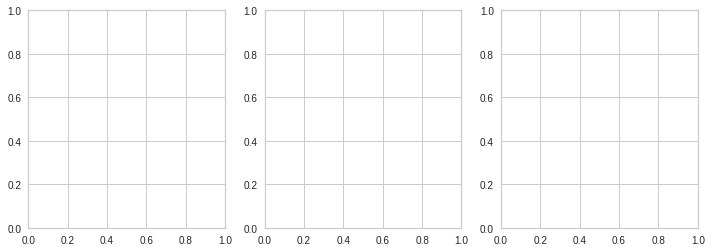

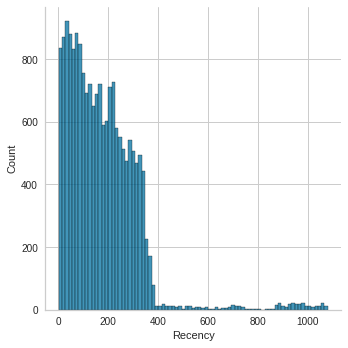

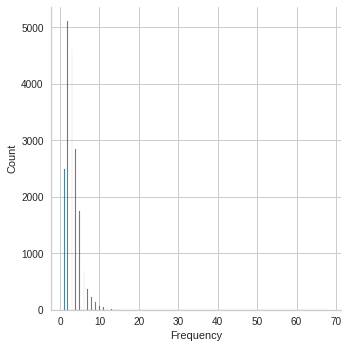

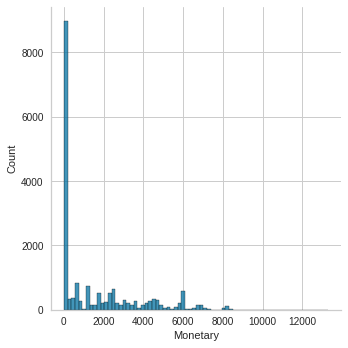

In [52]:
fig, ax = plt.subplots(1, 3, figsize = (12,4))
sns.displot(df_RFM['Recency'], ax = ax[0])
sns.displot(df_RFM['Frequency'], ax = ax[1])
sns.displot(df_RFM['Monetary'], ax = ax[2])
plt.show

In [53]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(df_RFM[x], ax=ax[0,0])
    sns.distplot(np.log(df_RFM[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(df_RFM[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(df_RFM[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(df_RFM[x].skew().round(2))
    print(np.log(df_RFM[x]).skew().round(2))
    print(np.sqrt(df_RFM[x]).skew().round(2))
    print(pd.Series(stats.boxcox(df_RFM[x])[0]).skew().round(2))

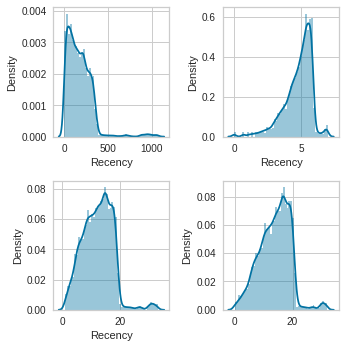

2.47
-1.29
0.46
0.0


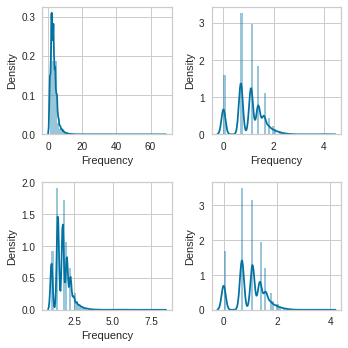

10.09
0.06
2.15
-0.0


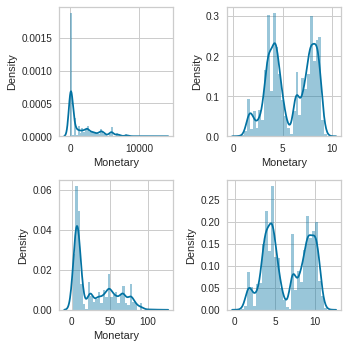

1.41
-0.12
0.68
-0.04


In [54]:
analyze_skewness('Recency')
analyze_skewness('Frequency')
analyze_skewness('Monetary')

In [55]:
from scipy.stats import kurtosis, skew, mode, boxcox
df_RFM['box_R']= boxcox(df_RFM['Recency'], 0)
df_RFM['box_F']= boxcox(df_RFM['Frequency'], 0)
df_RFM['box_M']= boxcox(df_RFM['Monetary'], 0)

In [56]:
scaler = StandardScaler()

# fit_transform
df_RFM['R_std'] = scaler.fit_transform(df_RFM[['Recency']])
df_RFM['F_std'] = scaler.fit_transform(df_RFM[['Frequency']])
df_RFM['M_std'] = scaler.fit_transform(df_RFM[['Monetary']])

In [57]:
df_RFM.head()

,Recency,Frequency,Monetary,box_R,box_F,box_M,R_std,F_std,M_std
CustomerKey,,,,,,,,,
11000,256,8,8248.99,5.545177,2.079442,9.017846,0.551579,1.805676,3.135647
11001,35,11,6383.88,3.555348,2.397895,8.761531,-0.965860,2.950340,2.257607
11002,325,4,8114.04,5.783825,1.386294,9.001351,1.025349,0.279457,3.072117
11003,249,9,8139.29,5.517453,2.197225,9.004458,0.503515,2.187231,3.084003
11004,258,6,8196.01,5.552960,1.791759,9.011403,0.565311,1.042567,3.110706


# **Elbow and Silhouette**

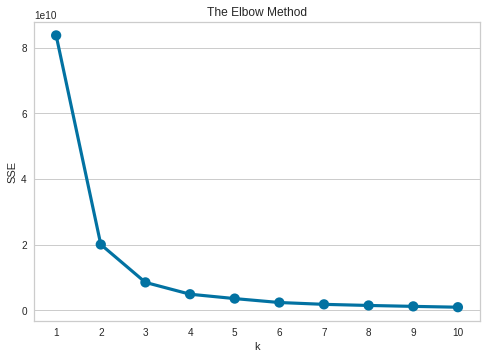

In [58]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_RFM)
    sse[k] = kmeans.inertia_ 
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

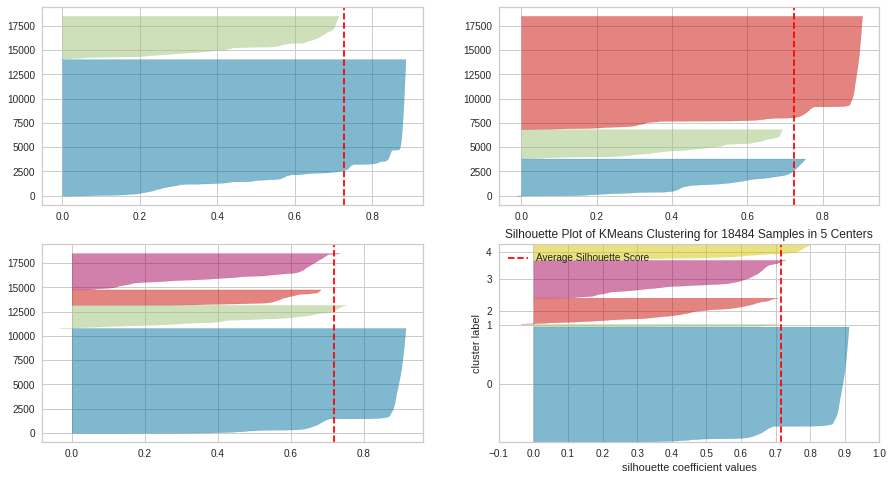

In [59]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2,3,4,5]:
  km = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, max_iter=100,random_state=42)
  q, mod = divmod(i, 2)
  visualizer = SilhouetteVisualizer(km, colors='yellowbrick',ax = ax[q-1][mod])
  visualizer.fit(df_RFM)        # Fit the data to the visualizer
visualizer.show()

In [60]:
wcss_silhouette = []
for i in range(2,10):
    km = KMeans(n_clusters=i, random_state=0,init='k-means++').fit(df_RFM)
    preds = km.predict(df_RFM)    
    silhouette = silhouette_score(df_RFM,preds)
    wcss_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

Silhouette score for number of cluster(s) 2: 0.7273800711992665
Silhouette score for number of cluster(s) 3: 0.724387251395058
Silhouette score for number of cluster(s) 4: 0.7168277872192209
Silhouette score for number of cluster(s) 5: 0.7169237072007237
Silhouette score for number of cluster(s) 6: 0.7047699434169762
Silhouette score for number of cluster(s) 7: 0.6739511484380106
Silhouette score for number of cluster(s) 8: 0.6737856513443905
Silhouette score for number of cluster(s) 9: 0.6599618772084407


# **Customer Segmentation with K-means**

In [61]:
model = KMeans(n_clusters=3 , random_state=42)
model.fit(df_RFM)

KMeans(n_clusters=3, random_state=42)

In [72]:
df_RFM['Cluster'] = model.labels_
df_RFM.head()

,Recency,Frequency,Monetary,box_R,box_F,box_M,R_std,F_std,M_std,Cluster
CustomerKey,,,,,,,,,,
11000,256,8,8248.99,5.545177,2.079442,9.017846,0.551579,1.805676,3.135647,1
11001,35,11,6383.88,3.555348,2.397895,8.761531,-0.965860,2.950340,2.257607,1
11002,325,4,8114.04,5.783825,1.386294,9.001351,1.025349,0.279457,3.072117,1
11003,249,9,8139.29,5.517453,2.197225,9.004458,0.503515,2.187231,3.084003,1
11004,258,6,8196.01,5.552960,1.791759,9.011403,0.565311,1.042567,3.110706,1


In [ ]:
df_RFM.groupby('Cluster').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'Monetary':'mean'
    }
).round(2)

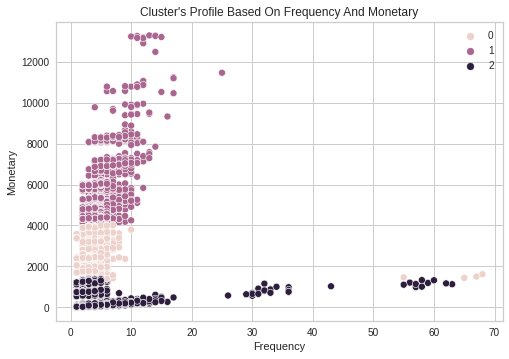

In [64]:
pl = sns.scatterplot(x=df_RFM["Frequency"], y=df_RFM["Monetary"],hue=df_RFM["Cluster"])
pl.set_title("Cluster's Profile Based On Frequency And Monetary")
plt.legend()
plt.show()

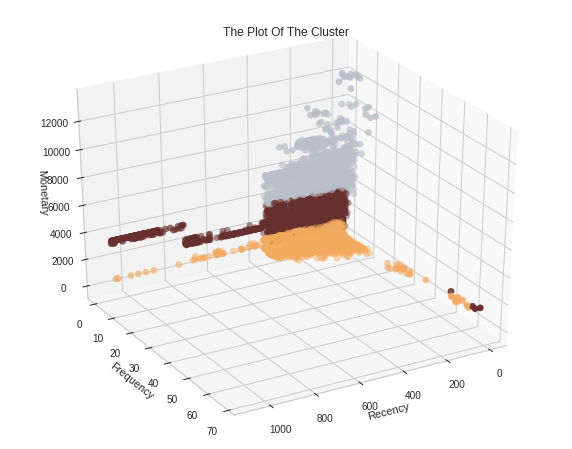

In [65]:
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
x=df_RFM['Recency']
y=df_RFM['Frequency']
z=df_RFM['Monetary']
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x,y,z, s=40, c=df_RFM["Cluster"], marker='o', cmap = cmap )
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title("The Plot Of The Cluster")
ax.view_init(30, 60)
label_legend = [0,1,2,3,4]
plt.show()

In [66]:
from collections import Counter
d= Counter(df_RFM['Cluster'])
print(d)

Counter({2: 11653, 0: 3821, 1: 3010})


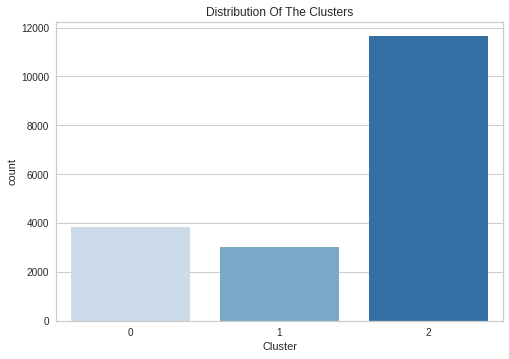

In [67]:
pl = sns.countplot(x=df_RFM['Cluster'], palette= 'Blues')
pl.set_title("Distribution Of The Clusters")
plt.show()

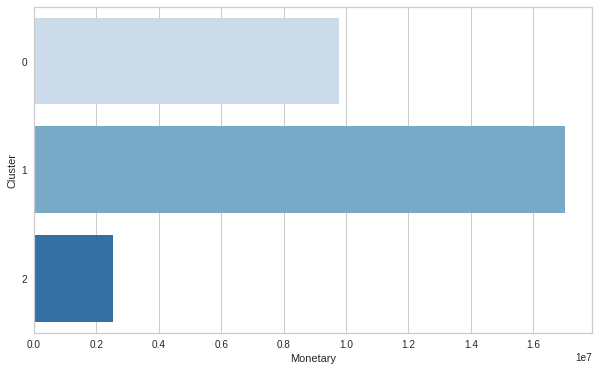

In [68]:
cluster =df_RFM.groupby('Cluster')['Monetary'].sum().reset_index().sort_values('Monetary', ascending = False)
plt.figure(figsize = (10,6))
sns.color_palette("Blues", as_cmap=True)
sns.barplot(x='Monetary', y='Cluster',data=cluster, orient = 'h', palette = 'Blues')

In [69]:
df_RFM.groupby('Cluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,3821.0,234.730960,234.566093,2.0,80.0,169.0,284.0,1081.0
1,3010.0,157.373090,98.365178,17.0,73.0,145.0,226.0,382.0
2,11653.0,161.026946,108.010306,1.0,68.0,151.0,246.0,1066.0


In [70]:
df_RFM.groupby('Cluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,3821.0,3.147344,2.423599,1.0,2.0,3.0,4.0,68.0
1,3010.0,4.788704,2.132657,2.0,3.0,4.0,6.0,25.0
2,11653.0,2.914099,2.658711,1.0,2.0,2.0,3.0,63.0


In [71]:
df_RFM.groupby('Cluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,3821.0,2562.013886,655.296984,1387.9500,2049.0982,2438.0600,3078.0582,4101.7575
1,3010.0,5655.344992,1308.959786,4112.7675,4539.4600,5710.0948,6070.0550,13295.3800
2,11653.0,218.538894,338.032071,2.2900,33.9800,69.8700,154.9800,1386.4800


# **CUSTOMER**

In [83]:
#@title New and Existing Customers
# Calculate Min purchase date
df_min_purchase = df_sales_data_final.groupby('CustomerKey').OrderDateKey.min().reset_index()
df_min_purchase.columns = ['CustomerKey', 'MinPurchaseDate']
df_min_purchase['MinPurchaseYearMonth'] = df_min_purchase['MinPurchaseDate'].map(lambda x: x.year*100 + x.month)

In [87]:
# Merge df_sales_data and df_min_purchase
df_sales_data_final = pd.merge(df_sales_data_final, df_min_purchase, on = 'CustomerKey')

In [88]:
df_sales_data_final['OrdYearMonth']= df_sales_data_final['OrderDateKey'].map(lambda x: x.year*100 + x.month)
df_sales_data_final['UserType'] = 'New'

In [89]:
df_sales_data_final

,SalesOrderLineKey,CustomerKey,OrderDateKey,SalesTerritoryKey,Sales Amount,OrdYearMonth,UserType,MinPurchaseDate,MinPurchaseYearMonth
0,43697001,21768,2017-07-01,6,3578.27,201707,New,2017-07-01,201707
1,56212001,21768,2019-09-15,6,539.99,201909,New,2017-07-01,201707
2,43698001,28389,2017-07-01,7,3399.99,201707,New,2017-07-01,201707
3,43699001,25863,2017-07-01,1,3399.99,201707,New,2017-07-01,201707
4,62866001,25863,2019-12-27,1,1214.85,201912,New,2017-07-01,201707
...,...,...,...,...,...,...,...,...,...
60393,75115003,26832,2020-06-15,8,54.99,202006,New,2020-06-15,202006
60394,75118001,13671,2020-06-15,8,4.99,202006,New,2020-06-15,202006
60395,75118002,13671,2020-06-15,8,2.29,202006,New,2020-06-15,202006
60396,75118003,13671,2020-06-15,8,7.95,202006,New,2020-06-15,202006


In [90]:
df_sales_data_final.loc[df_sales_data['OrdYearMonth'] != df_sales_data_final['MinPurchaseYearMonth'], 'UserType']='Existing'

In [91]:
df_sales_data_final['UserType'].value_counts()

New         37168
Existing    23230
Name: UserType, dtype: int64

In [93]:
df_user_type_revenue = df_sales_data_final.groupby(['OrdYearMonth', 'UserType'])['Sales Amount'].sum().reset_index()

In [94]:
df_user_type_revenue = df_user_type_revenue.query("OrdYearMonth != 202006")

In [96]:
plot_data = [
     go.Scatter(
         x=df_user_type_revenue.query("UserType == 'New'")['OrdYearMonth'],
         y=df_user_type_revenue.query("UserType == 'New'")['Sales Amount'],
         name = 'New'
    ),
    go.Scatter(
        x=df_user_type_revenue.query("UserType == 'Existing'")['OrdYearMonth'],
        y=df_user_type_revenue.query("UserType == 'Existing'")['Sales Amount'],
        name = 'Existing'
    )
   
]
plot_layout = go.Layout(
    xaxis={"type": "category"},
    title= 'Revenue of New vs Existing Customers'
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyoff.plot(fig)
fig.show()

In [97]:
#@title Monthly New Customers

# Count New customers
countNew = df_sales_data_final.query("UserType == 'New'").groupby(['OrdYearMonth'])['CustomerKey'].nunique()

# Count Existing customer
countExis = df_sales_data_final.query("UserType == 'Existing'").groupby(['OrdYearMonth'])['CustomerKey'].nunique()

In [98]:
# Calculate Users ratio
df_user_ratio = countNew/countExis
df_user_ratio = df_user_ratio.reset_index()
df_user_ratio = df_user_ratio.dropna()

In [99]:
plot_data = [
    go.Bar(
        x=df_user_ratio['OrdYearMonth'],
        y=df_user_ratio['CustomerKey'],
        marker = dict(color = '#65647C')
    )
]
plot_layout = go.Layout(
    xaxis={"type": "category"},
    title='New Customer Ratio'
)
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.plot(fig)
fig.show()

In [104]:
#@title Monthly Retention Rate
# Calculate Monthly Active Users
df_monthly_active = df_sales_data_final.groupby('OrdYearMonth')['CustomerKey'].nunique().reset_index()

In [102]:
# Calculate Monthly Customer Revenue
df_user_purchase = df_sales_data_final.groupby (['CustomerKey', 'OrdYearMonth'])['Sales Amount'].sum().astype(int).reset_index()

In [105]:
# Calculate Total Revenue
df_user_purchase.columns = ['CustomerKey', 'OrdYearMonth','Revenue']
df_user_purchase.Revenue.sum()

29340990

In [106]:
# Full Customer Status
df_retention = pd.crosstab(df_user_purchase['CustomerKey'], df_user_purchase['OrdYearMonth']).reset_index()

In [107]:
df_retention

OrdYearMonth,CustomerKey,201707,201708,201709,201710,201711,201712,201801,201802,201803,...,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006
0,11000,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,11001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,11002,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11003,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,11004,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18479,29479,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18480,29480,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
18481,29481,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18482,29482,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
months = df_retention.columns[23:]

In [109]:
months

Index([201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912, 202001,
       202002, 202003, 202004, 202005, 202006],
      dtype='object', name='OrdYearMonth')

In [ ]:
# Remove months don't have Existing Customer (05/2019 ago)
# df_retention.drop(df_retention.iloc[:, 1:23], inplace = True, axis = 1)

In [110]:
df_retention[(df_retention[201905] == 1) & (df_retention[201906] == 1)][201906].sum()

10

In [111]:
retention_array = []
for i in range(len(months)-1):
  retention_data = {}
  selected_month = months[i+1]
  prev_month = months[i]
  retention_data['OrdYearMonth'] = int(selected_month)
  retention_data['TotalUserCount'] = df_retention[selected_month].sum()
  retention_data['RetainedUserCount'] = df_retention[(df_retention[selected_month]==1) & (df_retention[prev_month]==1)][selected_month].sum()
  retention_array.append(retention_data)
  print("********************" + str(selected_month)+ "********************")
  print(retention_array)

********************201906********************
[{'OrdYearMonth': 201906, 'TotalUserCount': 498, 'RetainedUserCount': 10}]
********************201907********************
[{'OrdYearMonth': 201906, 'TotalUserCount': 498, 'RetainedUserCount': 10}, {'OrdYearMonth': 201907, 'TotalUserCount': 1509, 'RetainedUserCount': 3}]
********************201908********************
[{'OrdYearMonth': 201906, 'TotalUserCount': 498, 'RetainedUserCount': 10}, {'OrdYearMonth': 201907, 'TotalUserCount': 1509, 'RetainedUserCount': 3}, {'OrdYearMonth': 201908, 'TotalUserCount': 1604, 'RetainedUserCount': 71}]
********************201909********************
[{'OrdYearMonth': 201906, 'TotalUserCount': 498, 'RetainedUserCount': 10}, {'OrdYearMonth': 201907, 'TotalUserCount': 1509, 'RetainedUserCount': 3}, {'OrdYearMonth': 201908, 'TotalUserCount': 1604, 'RetainedUserCount': 71}, {'OrdYearMonth': 201909, 'TotalUserCount': 1576, 'RetainedUserCount': 80}]
********************201910********************
[{'OrdYearMonth': 

In [112]:
df_retention = pd.DataFrame(retention_array)

In [113]:
df_retention['RetentionRate(%)'] = (df_retention['RetainedUserCount']/df_retention['TotalUserCount'])*100

In [114]:
df_retention

,OrdYearMonth,TotalUserCount,RetainedUserCount,RetentionRate(%)
0,201906,498,10,2.008032
1,201907,1509,3,0.198807
2,201908,1604,71,4.426434
3,201909,1576,80,5.076142
4,201910,1698,73,4.299176
5,201911,1972,83,4.208925
6,201912,1777,78,4.389420
7,202001,1917,78,4.068858
8,202002,1757,81,4.610131
9,202003,2072,80,3.861004


In [115]:
plot_data = [
    go.Scatter(
        x=df_retention['OrdYearMonth'],
        y=df_retention['RetentionRate(%)'],
        name='organic',
        marker = dict (color = '#98A8F8')
       
    )
]
plot_layout = go.Layout(
    xaxis={"type": "category"},
    title='Monthly Retention Rate'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.plot(fig)
fig.show()

## Monthly Churn rate

In [116]:
df_retention['ChurnRate(%)'] = 100 - df_retention['RetentionRate(%)']

In [117]:
df_retention

,OrdYearMonth,TotalUserCount,RetainedUserCount,RetentionRate(%),ChurnRate(%)
0,201906,498,10,2.008032,97.991968
1,201907,1509,3,0.198807,99.801193
2,201908,1604,71,4.426434,95.573566
3,201909,1576,80,5.076142,94.923858
4,201910,1698,73,4.299176,95.700824
5,201911,1972,83,4.208925,95.791075
6,201912,1777,78,4.389420,95.610580
7,202001,1917,78,4.068858,95.931142
8,202002,1757,81,4.610131,95.389869
9,202003,2072,80,3.861004,96.138996


In [118]:
plot_data = [
    go.Scatter(
        x=df_retention['OrdYearMonth'],
        y=df_retention['ChurnRate(%)'],
        name='organic',
        marker = dict (color = '#FF8787')
       
    )
]
plot_layout = go.Layout(
    xaxis={"type": "category"},
    title='Monthly Churn Rate'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.plot(fig)
fig.show()

# Cohort Base Retention

In [119]:
df_user_purchase

,CustomerKey,OrdYearMonth,Revenue
0,11000,201707,3399
1,11000,201906,2341
2,11000,201910,2507
3,11001,201707,3374
4,11001,201906,2419
...,...,...,...
26941,29479,201902,2049
26942,29480,201912,2442
26943,29481,201801,3374
26944,29482,201902,2049


In [120]:
df_min_purchase

,CustomerKey,MinPurchaseDate,MinPurchaseYearMonth
0,11000,2017-07-12,201707
1,11001,2017-07-09,201707
2,11002,2017-07-05,201707
3,11003,2017-07-01,201707
4,11004,2017-07-14,201707
...,...,...,...
18479,29479,2019-02-05,201902
18480,29480,2019-12-18,201912
18481,29481,2018-01-13,201801
18482,29482,2019-02-19,201902


In [121]:
df_retention = pd.crosstab(df_user_purchase['CustomerKey'], df_user_purchase['OrdYearMonth']).reset_index()

In [122]:
df_retention

OrdYearMonth,CustomerKey,201707,201708,201709,201710,201711,201712,201801,201802,201803,...,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006
0,11000,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,11001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,11002,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11003,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,11004,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18479,29479,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18480,29480,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
18481,29481,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18482,29482,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [123]:
df_retention = pd.merge(df_retention, df_min_purchase[['CustomerKey','MinPurchaseYearMonth']], on = 'CustomerKey')

In [124]:
df_retention

,CustomerKey,201707,201708,201709,201710,201711,201712,201801,201802,201803,...,201910,201911,201912,202001,202002,202003,202004,202005,202006,MinPurchaseYearMonth
0,11000,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,201707
1,11001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,201707
2,11002,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,201707
3,11003,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,201707
4,11004,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,201707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18479,29479,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,201902
18480,29480,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,201912
18481,29481,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,201801
18482,29482,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,201902


In [125]:
new_column_names = ['m_' + str(column) for column in df_retention.columns[:-1]]

In [126]:
new_column_names.append('MinPurchaseYearMonth')

In [127]:
df_retention.columns = new_column_names

In [128]:
df_retention

,m_CustomerKey,m_201707,m_201708,m_201709,m_201710,m_201711,m_201712,m_201801,m_201802,m_201803,...,m_201910,m_201911,m_201912,m_202001,m_202002,m_202003,m_202004,m_202005,m_202006,MinPurchaseYearMonth
0,11000,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,201707
1,11001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,201707
2,11002,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,201707
3,11003,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,201707
4,11004,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,201707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18479,29479,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,201902
18480,29480,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,201912
18481,29481,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,201801
18482,29482,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,201902


In [129]:
from datetime import datetime
a = '201602'
date = datetime.strptime(a, '%Y%m').strftime('%B %Y')

In [130]:
a = []

for i in months:
  date = datetime.strptime(str(i), '%Y%m').strftime('%B %Y')
  a.append(date)

In [131]:
a

['May 2019',
 'June 2019',
 'July 2019',
 'August 2019',
 'September 2019',
 'October 2019',
 'November 2019',
 'December 2019',
 'January 2020',
 'February 2020',
 'March 2020',
 'April 2020',
 'May 2020',
 'June 2020']

In [132]:
total_user_count = df_retention[df_retention['MinPurchaseYearMonth'] == 201907]['MinPurchaseYearMonth'].count()

In [133]:
total_user_count

1210

In [134]:
df_retention.query("MinPurchaseYearMonth == 201907 and {} == 1".format(str('m_' + str(201908))))['m_' + str(201908)].sum()/total_user_count

0.05785123966942149

In [135]:
retention_array = []
for i in range(len(months)):
  retention_data = {}
  selected_month = months[i]
  prev_months = months[:i]
  next_months = months[i+1:]
  for prev_month in prev_months:
    retention_data[prev_month] = np.nan

  total_user_count = df_retention[df_retention.MinPurchaseYearMonth == selected_month].MinPurchaseYearMonth.count()
  retention_data['TotalUserCount'] = total_user_count
  retention_data[selected_month] = 1
  query = "MinPurchaseYearMonth == {}".format(selected_month)

  for next_month in next_months:
    new_query = query + "and {} > 0".format(str('m_' + str(next_month)))
    retention_data[next_month] = np.round(df_retention.query(new_query)['m_' + str(next_month)].sum()/total_user_count,2)
  retention_array.append(retention_data)  
df_retention = pd.DataFrame(retention_array)

In [136]:
df_retention.index = a

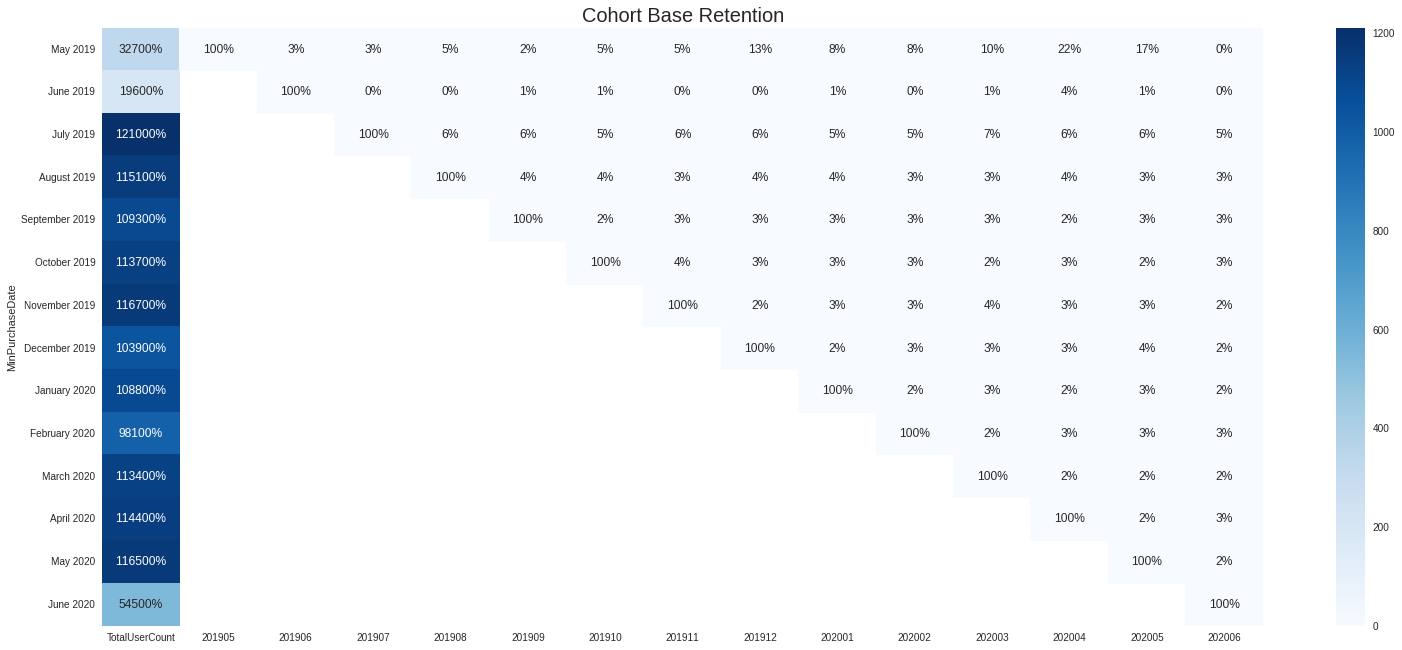

In [137]:
fig, ax = plt.subplots(1,1,figsize = (26,11))
plt.title('Cohort Base Retention', size = 20)
sns.heatmap(df_retention, annot = True, fmt='.0%', cmap ="Blues")
ax.set_ylabel('MinPurchaseDate')

plt.show()

In [138]:
df_retention['TotalUserCount']

May 2019           327
June 2019          196
July 2019         1210
August 2019       1151
September 2019    1093
October 2019      1137
November 2019     1167
December 2019     1039
January 2020      1088
February 2020      981
March 2020        1134
April 2020        1144
May 2020          1165
June 2020          545
Name: TotalUserCount, dtype: int64

# **CLV Predict**

In [73]:
from datetime import date

In [75]:
df_sales_data_final['OrderDateKey'] = pd.to_datetime(df_sales_data_final['OrderDateKey']).dt.date
df_6months = df_sales_data_final[(df_sales_data_final.OrderDateKey >= date(2019, 9, 1)) & (df_sales_data_final.OrderDateKey < date(2020,3,1))].reset_index(drop=False)

In [140]:
df_6months_user = df_6months.groupby('CustomerKey')['Sales Amount'].sum().reset_index()
df_6months_user.columns = ['CustomerKey', 'm6_Revenue']

In [141]:
#Visualize
plot_data = [
    go.Histogram(
        x = df_6months_user['m6_Revenue']
    )
]
plot_layout = go.Layout(
    xaxis= dict(title = "m6_Revenue"),
    yaxis= dict(title = "Count of users"),
    title = '6m Revenue'
)
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.plot(fig)
fig.show()

In [143]:
df_merge = pd.merge(df_RFM, df_6months_user, on = 'CustomerKey', how = 'left')
df_merge = df_merge.fillna(0)

In [146]:
# Remove outlier
df_merge = df_merge[df_merge['m6_Revenue'] < df_merge['m6_Revenue'].quantile(0.99)]

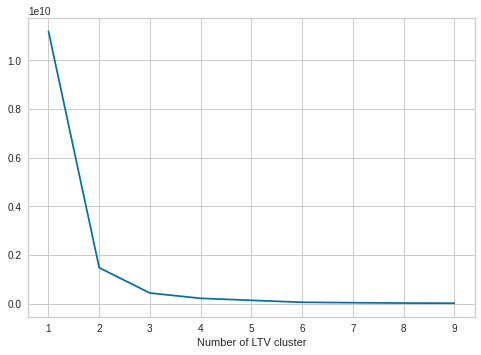

In [147]:
sse={}
df_RFM_frequency = df_merge[['m6_Revenue']]
for k in range(1,10):
  kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_RFM_frequency)
  df_RFM_frequency["clusters"] = kmeans.labels_
  sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of LTV cluster")
plt.show()

In [148]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_merge[['m6_Revenue']])
df_merge['LTVCluster'] = kmeans.predict(df_merge[['m6_Revenue']])

In [149]:
df_new = df_merge.groupby('LTVCluster')['m6_Revenue'].mean().reset_index()
df_new = df_new.sort_values(by='m6_Revenue', ascending=True).reset_index(drop=True)
df_new['index']=df_new.index
df_merge = pd.merge(df_merge, df_new[['LTVCluster','index']], on='LTVCluster')
df_merge = df_merge.drop(['LTVCluster'], axis=1)
df_merge = df_merge.rename(columns={"index":'LTVCluster'})
df_merge

,CustomerKey,Recency,Frequency,Monetary,box_R,box_F,box_M,R_std,F_std,M_std,Cluster,m6_Revenue,LTVCluster
0,11000,256,8,8248.99,5.545177,2.079442,9.017846,0.551579,1.805676,3.135647,1,2507.03,2
1,11003,249,9,8139.29,5.517453,2.197225,9.004458,0.503515,2.187231,3.084003,1,2420.34,2
2,11004,258,6,8196.01,5.552960,1.791759,9.011403,0.565311,1.042567,3.110706,1,2419.06,2
3,11005,257,6,8121.33,5.549076,1.791759,9.002249,0.558445,1.042567,3.075548,1,2384.07,2
4,11006,245,5,8119.03,5.501258,1.609438,9.001966,0.476050,0.661012,3.074466,1,2384.07,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18294,29456,128,4,765.32,4.852030,1.386294,6.640294,-0.327300,0.279457,-0.387449,2,765.32,1
18295,29457,124,3,756.33,4.820282,1.098612,6.628478,-0.354765,-0.102097,-0.391681,2,756.33,1
18296,29458,122,4,811.32,4.804021,1.386294,6.698663,-0.368497,0.279457,-0.365794,2,811.32,1
18297,29459,117,3,805.33,4.762174,1.098612,6.691252,-0.402828,-0.102097,-0.368613,2,805.33,1


In [150]:
df_cluster = df_merge.copy()
df_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,13889.0,21.548201,39.781657,0.00,0.00,0.00,32.60,416.30
1,2093.0,816.084959,259.413230,453.63,574.98,758.62,1145.48,1438.80
2,2317.0,2303.355442,343.544468,1587.81,2316.97,2374.98,2433.04,4134.94


In [151]:
# Convert categorical columns to numerical
df_class = pd.get_dummies(df_cluster)
df_class.head()

,CustomerKey,Recency,Frequency,Monetary,box_R,box_F,box_M,R_std,F_std,M_std,Cluster,m6_Revenue,LTVCluster
0,11000,256,8,8248.99,5.545177,2.079442,9.017846,0.551579,1.805676,3.135647,1,2507.03,2
1,11003,249,9,8139.29,5.517453,2.197225,9.004458,0.503515,2.187231,3.084003,1,2420.34,2
2,11004,258,6,8196.01,5.552960,1.791759,9.011403,0.565311,1.042567,3.110706,1,2419.06,2
3,11005,257,6,8121.33,5.549076,1.791759,9.002249,0.558445,1.042567,3.075548,1,2384.07,2
4,11006,245,5,8119.03,5.501258,1.609438,9.001966,0.476050,0.661012,3.074466,1,2384.07,2


In [152]:
# Calculate and show correlations
corr_matrix = df_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending = False)
corr_matrix.style.background_gradient(cmap = 'coolwarm').set_precision(2)

,CustomerKey,Recency,Frequency,Monetary,box_R,box_F,box_M,R_std,F_std,M_std,Cluster,m6_Revenue,LTVCluster
CustomerKey,1.00,0.22,-0.32,-0.23,0.15,-0.37,-0.12,0.22,-0.32,-0.23,0.05,-0.18,-0.15
Recency,0.22,1.00,-0.20,0.08,0.79,-0.29,0.11,1.00,-0.20,0.08,-0.18,0.00,0.01
Frequency,-0.32,-0.20,1.00,0.26,-0.22,0.78,0.28,-0.20,1.00,0.26,-0.09,0.20,0.19
Monetary,-0.23,0.08,0.26,1.00,0.08,0.36,0.83,0.08,0.26,1.00,-0.63,0.59,0.57
box_R,0.15,0.79,-0.22,0.08,1.00,-0.21,0.09,0.79,-0.22,0.08,-0.13,0.14,0.15
box_F,-0.37,-0.29,0.78,0.36,-0.21,1.00,0.41,-0.29,0.78,0.36,-0.15,0.28,0.26
box_M,-0.12,0.11,0.28,0.83,0.09,0.41,1.00,0.11,0.28,0.83,-0.74,0.53,0.55
R_std,0.22,1.00,-0.20,0.08,0.79,-0.29,0.11,1.00,-0.20,0.08,-0.18,0.00,0.01
F_std,-0.32,-0.20,1.00,0.26,-0.22,0.78,0.28,-0.20,1.00,0.26,-0.09,0.20,0.19
M_std,-0.23,0.08,0.26,1.00,0.08,0.36,0.83,0.08,0.26,1.00,-0.63,0.59,0.57


In [153]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [154]:
# Create x and y, x will be feature set and y is the label 
X = df_class.drop(['LTVCluster', 'm6_Revenue'], axis = 1)
y = df_class['LTVCluster']

In [155]:
# Split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 56)

In [156]:
#save the data
X_train.to_csv('X_train.csv',index=False)
X_test.to_csv('X_test.csv',index=False)
y_train.to_csv('y_train.csv', index = False)
y_train.to_csv('y_test.csv', index = False)

In [157]:
# XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth = 5, learning_rate = 0.1, objective = 'multi:softprob', n_jobs = -1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'.format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on training set: {:.2f}'.format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.99
Accuracy of XGB classifier on training set: 0.98


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4117
           1       0.95      0.92      0.94       664
           2       0.93      0.95      0.94       709

    accuracy                           0.98      5490
   macro avg       0.96      0.96      0.96      5490
weighted avg       0.98      0.98      0.98      5490



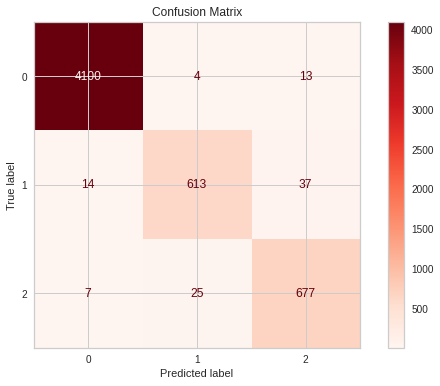

In [158]:
y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

matrix = plot_confusion_matrix(ltv_xgb_model, X_test, y_test, cmap = plt.cm.Reds)
matrix.ax_.set_title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.gcf().axes[0].tick_params(color = 'white')
plt.gcf().axes[1].tick_params(color = 'white')
plt.gcf().set_size_inches(10,6)
plt.show()

In [160]:
df_class.groupby('LTVCluster').CustomerKey.count()/df_class.CustomerKey.count()

LTVCluster
0    0.759003
1    0.114378
2    0.126619
Name: CustomerKey, dtype: float64

In [161]:
df_class

,CustomerKey,Recency,Frequency,Monetary,box_R,box_F,box_M,R_std,F_std,M_std,Cluster,m6_Revenue,LTVCluster
0,11000,256,8,8248.99,5.545177,2.079442,9.017846,0.551579,1.805676,3.135647,1,2507.03,2
1,11003,249,9,8139.29,5.517453,2.197225,9.004458,0.503515,2.187231,3.084003,1,2420.34,2
2,11004,258,6,8196.01,5.552960,1.791759,9.011403,0.565311,1.042567,3.110706,1,2419.06,2
3,11005,257,6,8121.33,5.549076,1.791759,9.002249,0.558445,1.042567,3.075548,1,2384.07,2
4,11006,245,5,8119.03,5.501258,1.609438,9.001966,0.476050,0.661012,3.074466,1,2384.07,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18294,29456,128,4,765.32,4.852030,1.386294,6.640294,-0.327300,0.279457,-0.387449,2,765.32,1
18295,29457,124,3,756.33,4.820282,1.098612,6.628478,-0.354765,-0.102097,-0.391681,2,756.33,1
18296,29458,122,4,811.32,4.804021,1.386294,6.698663,-0.368497,0.279457,-0.365794,2,811.32,1
18297,29459,117,3,805.33,4.762174,1.098612,6.691252,-0.402828,-0.102097,-0.368613,2,805.33,1
